# This code loads main screen data, assign cells to guides, and create the object Rd3_Data_post_sgRNA_rescue-reseq.h5ad

### Note that as a second dataset failed, we refer to Rd3 as the 'round 3' data

In [1]:
import pandas as pd
from pathlib import Path
import json

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re
import dask.dataframe as dd
import anndata as ad
from anndata import AnnData
#import relation_data_lake as rdl
import scipy.sparse as sp
import scanpy as sc

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

DIR_DATA_RNA = "../../data_raw/rna/"
DIR_DATA_GENERATED = Path("../../data_generated")
DIR_PLOTS = Path("../../plots")

In [5]:
fibro_processed_names = [
    'GSM8151754_exVivo_OP2_IL1b_1',
    'GSM8151755_exVivo_OP2_IL1b_2',
    'GSM8151756_exVivo_OP2_resting_1',
    'GSM8151757_exVivo_OP2_resting_2',
    'GSM8151758_exVivo_OP2_TGFb_1',
    'GSM8151759_exVivo_OP2_TGFb_2'
]

In [6]:
cell2guides = []
for fibro_processed_name in fibro_processed_names:
    f_path = (DIR_DATA_RNA +
              fibro_processed_name +
              '_protospacer_calls_per_cell.csv.gz')
    cell2guide = pd.read_csv(f_path, index_col='cell_barcode').drop(columns = ['num_features'])
    cell2guide = cell2guide.apply(lambda col: col.str.split('|'))
    cell2guide = cell2guide.apply(pd.Series.explode)
    cell2guide = cell2guide.pivot(columns='feature_call', values='num_umis').fillna(0)
    cell2guide.index = cell2guide.index + '-' + fibro_processed_name.split('_', 1)[1]
    #print(cell2guide.columns)
    cell2guides.append(cell2guide)

In [7]:
cell2guides = pd.concat(cell2guides) # .astype(int)
cell2guides[pd.isna(cell2guides)] = 0
cell2guides = cell2guides.astype(int)
counts_matrix = cell2guides.copy()

# Step 1: Filter low expressed counts that represent only a small fraction of total counts.

In [8]:
freq_matrix = counts_matrix / counts_matrix.sum(axis=1).values[:,None]
log_freq_matrix = np.log10( 1 + counts_matrix ) / np.log10(1 + counts_matrix.sum(axis=1).values[:,None] )

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) )
                       })
df

/tmp/ipykernel_113748/234126711.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) )


,cell_id,total_counts,log_total_counts,freq,log_freq,sgRNA_counts,log_sgRNA_counts
0,AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,291,2.463893,0.0,0.0,0,-inf
1,AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,1910,3.281033,0.0,0.0,0,-inf
2,AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,30,1.477121,0.0,0.0,0,-inf
3,AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,159,2.201397,0.0,0.0,0,-inf
4,AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,281,2.448706,0.0,0.0,0,-inf
...,...,...,...,...,...,...,...
1334309,TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2,24,1.380211,0.0,0.0,0,-inf
1334310,TTTCCTCTCTGCGAGC-1-exVivo_OP2_TGFb_2,533,2.726727,0.0,0.0,0,-inf
1334311,TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2,1002,3.000868,0.0,0.0,0,-inf
1334312,TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2,2428,3.385249,0.0,0.0,0,-inf


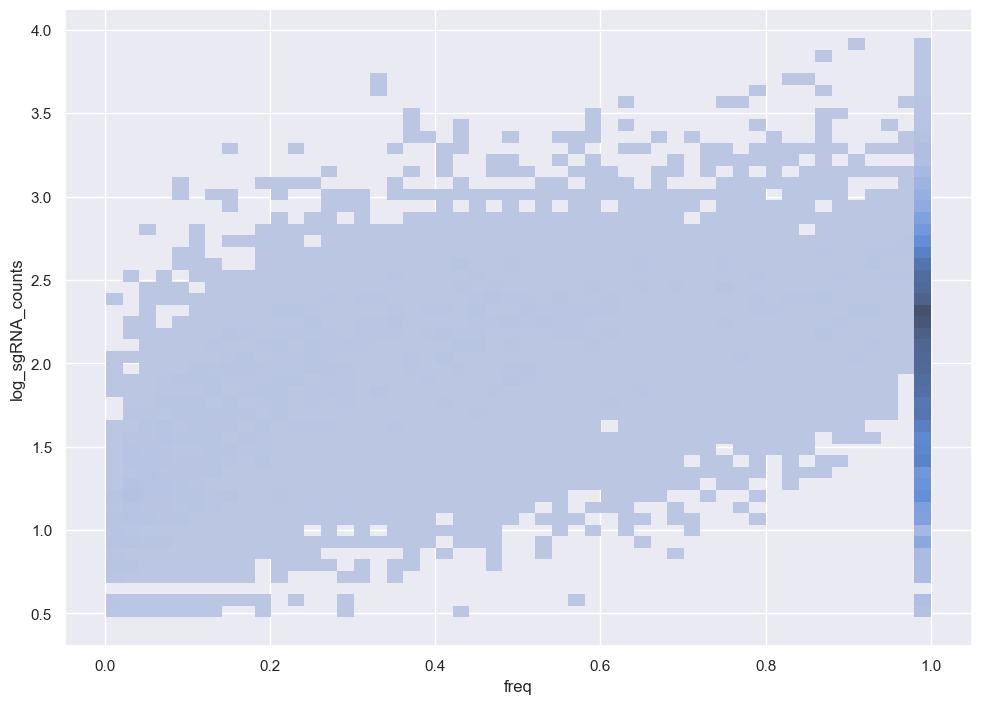

<Figure size 1170x827 with 0 Axes>

In [9]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig(DIR_PLOTS / "sgRNA_density_plot_Rd3", dpi=400)
plt.show()
plt.clf()

In [10]:
counts_matrix_filtered = counts_matrix.copy()
counts_matrix_filtered[(freq_matrix <= 0.175) & (counts_matrix <= 10**1.75)] = 0

In [11]:
freq_matrix = counts_matrix_filtered / counts_matrix_filtered.sum(axis=1).values[:,None]
log_freq_matrix = np.log10( 1 + counts_matrix_filtered ) / np.log10(1 + counts_matrix_filtered.sum(axis=1).values[:,None] )

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix_filtered.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix_filtered.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) )
                       })

/tmp/ipykernel_113748/3084429904.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) )


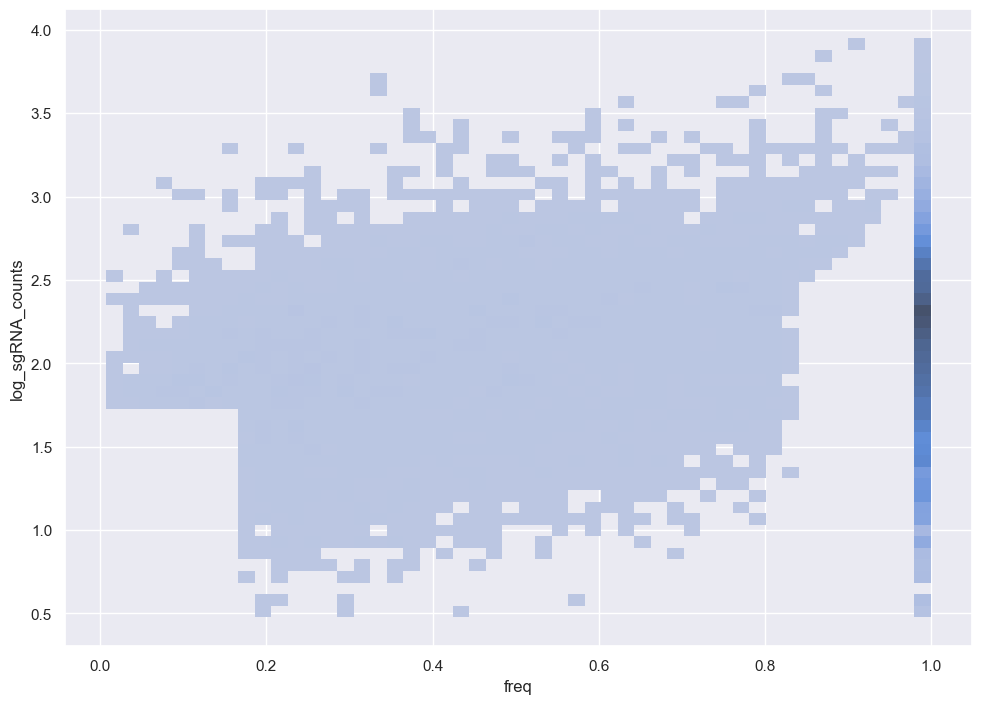

<Figure size 1170x827 with 0 Axes>

In [12]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig(DIR_PLOTS / "sgRNA_density_plot_filtered_Rd3", dpi=400)
plt.show()
plt.clf()

# Step 2: Map MOI=2 cells to MOI=1 when sgRNAs correspond to same gene, or with a targeting gene & NTC

In [13]:
def combine_columns_and_delete(counts_matrix_filtered, col1, col2, new_col):
    counts_matrix_filtered[new_col] = counts_matrix_filtered[col1] + counts_matrix_filtered[col2]
    counts_matrix_filtered = counts_matrix_filtered.drop(columns=[col1, col2])
    return counts_matrix_filtered

In [14]:
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'NTC_0005','NTC_0006','non-targeting')


In [15]:
counts_matrix_filtered.columns

Index(['Arid2_As_73066', 'Arid2_As_73067', 'Brd7_As_70314', 'Brd7_As_70316',
       'Brd9_As_70306', 'Brd9_As_70308', 'Chd4_As_66308', 'Chd4_As_66309',
       'Dmap1_As_60920', 'Dmap1_As_60922', 'EGR2_2', 'EGR2_3',
       'Hcfc1_As_49709', 'Hcfc1_As_49711', 'Ino80_As_46860', 'Ino80_As_46861',
       'Kansl1_As_45908', 'Kansl1_As_45909', 'Kat5_Br_45092', 'Kat5_Br_45093',
       'Kat8_As_45860', 'Kat8_As_45861', 'Kmt2a_As_44476', 'Kmt2a_Br_53969',
       'Paxip1_As_28665', 'Paxip1_As_28666', 'Pbrm1_As_28642',
       'Pbrm1_As_28643', 'Rest_As_21510', 'Rest_As_21511', 'Rnf40_As_20441',
       'Rnf40_As_20442', 'Setd1b_As_17785', 'Setd1b_Br_52333',
       'Setdb1_B_17753', 'Setdb1_B_17754', 'Smad2_1', 'Smad2_2', 'Smad3_1',
       'Smad4_1', 'Smarca4_As_15193', 'Smarca4_As_15194', 'Smarcd1_As_15167',
       'Smarcd1_Br_45407', 'Srcap_As_77988', 'Srcap_As_77989', 'TGFbR_1',
       'TGFbR_3', 'Tfpt_As_10465', 'Tfpt_As_10466', 'Wdr82_As_3096',
       'Wdr82_As_3097', 'Yeats4_As_2486', 'Yeats4_

In [16]:
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Arid2_As_73066', 'Arid2_As_73067','Arid2')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Brd7_As_70314', 'Brd7_As_70316','Brd7')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Brd9_As_70306', 'Brd9_As_70308','Brd9')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Hcfc1_As_49709', 'Hcfc1_As_49711','Hcfc1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kansl1_As_45908', 'Kansl1_As_45909','Kansl1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat5_Br_45092', 'Kat5_Br_45093','Kat5')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat8_As_45860', 'Kat8_As_45861','Kat8')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered, 'Pbrm1_As_28642', 'Pbrm1_As_28643','Pbrm1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smarcd1_As_15167', 'Smarcd1_Br_45407','Smarcd1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Wdr82_As_3096', 'Wdr82_As_3097','Wdr82')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Chd4_As_66308','Chd4_As_66309','Chd4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'EGR2_2', 'EGR2_3','Egr2')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kmt2a_As_44476','Kmt2a_Br_53969','Kmt2a')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Paxip1_As_28665', 'Paxip1_As_28666','Paxip1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Rest_As_21510', 'Rest_As_21511','Rest')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Rnf40_As_20441','Rnf40_As_20442','Rnf40')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Setd1b_As_17785', 'Setd1b_Br_52333','Setd1b')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered, 'Setdb1_B_17753', 'Setdb1_B_17754','Setdb1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smad2_1', 'Smad2_2','Smad2')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smarca4_As_15193', 'Smarca4_As_15194','Smarca4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Tfpt_As_10465', 'Tfpt_As_10466','Tfpt')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Yeats4_As_2486', 'Yeats4_As_2487','Yeats4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Dmap1_As_60920', 'Dmap1_As_60922','Dmap1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Ino80_As_46860', 'Ino80_As_46861','Ino80')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Srcap_As_77988', 'Srcap_As_77989','Srcap')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Yy1_As_2358', 'Yy1_As_2359','Yy1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Znhit1_As_220', 'Znhit1_As_222','Znhit1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smad4_3', 'Smad4_1','Smad4')

counts_matrix_filtered = counts_matrix_filtered.rename(columns={"Smad3_1":"Smad3"})




counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'TGFbR_3', 'TGFbR_1','Tgfbr1')
counts_matrix_filtered = counts_matrix_filtered.rename(columns={'TGFbR_1':'Tgfbr1'})


In [17]:
counts_matrix_filtered

feature_call,Smad3,non-targeting,Arid2,Brd7,Brd9,Hcfc1,Kansl1,Kat5,Kat8,Pbrm1,...,Smarca4,Tfpt,Yeats4,Dmap1,Ino80,Srcap,Yy1,Znhit1,Smad4,Tgfbr1
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,0,0,0,1910,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,30,0,0,0,0,0,0,0
AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTCCTCTCTGCGAGC-1-exVivo_OP2_TGFb_2,0,0,0,443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
counts_matrix_filtered.sum()

feature_call
Smad3            189191
non-targeting    199538
Arid2            120970
Brd7             453910
Brd9             134636
Hcfc1             98655
Kansl1            88679
Kat5             211928
Kat8             187928
Pbrm1            354022
Smarcd1          279276
Wdr82             76391
Chd4             114631
Egr2             305473
Kmt2a            244040
Paxip1           215017
Rest             519036
Rnf40            105957
Setd1b           212359
Setdb1           517211
Smad2            194281
Smarca4          156809
Tfpt             124082
Yeats4            68404
Dmap1             18108
Ino80             93542
Srcap             76458
Yy1              119596
Znhit1           369684
Smad4            126915
Tgfbr1           105127
dtype: int64

In [19]:
counts_matrix_filtered.columns

Index(['Smad3', 'non-targeting', 'Arid2', 'Brd7', 'Brd9', 'Hcfc1', 'Kansl1',
       'Kat5', 'Kat8', 'Pbrm1', 'Smarcd1', 'Wdr82', 'Chd4', 'Egr2', 'Kmt2a',
       'Paxip1', 'Rest', 'Rnf40', 'Setd1b', 'Setdb1', 'Smad2', 'Smarca4',
       'Tfpt', 'Yeats4', 'Dmap1', 'Ino80', 'Srcap', 'Yy1', 'Znhit1', 'Smad4',
       'Tgfbr1'],
      dtype='object', name='feature_call')

In [20]:
MOI1_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==1, axis=1)]
MOI2_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==2, axis=1)]

In [21]:
MOI2_cells['non-targeting'] = 0
MOI1_rescue = MOI2_cells[(MOI2_cells >0).apply(lambda row: sum(row)==1, axis=1)]

/tmp/ipykernel_113748/2051351486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOI2_cells['non-targeting'] = 0


In [22]:
cells_to_keep = pd.concat([MOI1_cells, MOI1_rescue])
cells_to_keep['target_max'] = cells_to_keep.idxmax(axis=1)
cells_to_keep = cells_to_keep.drop(columns=counts_matrix_filtered.columns.unique())


In [23]:
cells_to_keep

feature_call,target_max
cell_barcode,
AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,Kmt2a
AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,Brd7
AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,Yeats4
AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,Egr2
AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,Setd1b
...,...
GTCGTTCGTTATGTCG-1-exVivo_OP2_TGFb_2,Brd9
GTGGAAGGTCCGGTGT-1-exVivo_OP2_TGFb_2,Setdb1
TCGTGCTAGTTACTCG-1-exVivo_OP2_TGFb_2,Egr2


In [24]:
cells_to_keep['cell_barcode_corrected'] = 0
cells_to_keep['cell_barcode_old'] = cells_to_keep.index
cells_to_keep['condition'] = 'NaN'
cells_to_keep['batch'] = 'NaN'
for cb in cells_to_keep.index:
    if 'resting' in cb:
        state1 = 'Resting'
        if 'resting_1' in cb:
            state2 = 'Rep5-Resting'
        else:
            state2 = 'Rep6-Resting'
    if 'TGFb' in cb:
        state1 = 'Tgfb1'
        if 'TGFb_1' in cb:
            state2 = 'Rep7-Tgfb1'
        else:
            state2 = 'Rep8-Tgfb1'
    if 'IL1b' in cb:
        state1 = 'Il1b'
        if 'IL1b_1' in cb:
            state2 = 'Rep9-Il1b'
        else:
            state2 = 'Rep10-Il1b'
    cells_to_keep['condition'].loc[cb] = state1
    cells_to_keep['batch'].loc[cb] = state2
    cells_to_keep['cell_barcode_corrected'].loc[cb] = cb[0:16] + '-' + state2
    cells_to_keep['cell_barcode_old'].loc[cb] = cb[0:18]
cells_to_keep = cells_to_keep.set_index('cell_barcode_corrected')


/tmp/ipykernel_113748/3966255003.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['condition'].loc[cb] = state1
/tmp/ipykernel_113748/3966255003.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['batch'].loc[cb] = state2
/tmp/ipykernel_113748/3966255003.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['cell_barcode_corrected'].loc[cb] = cb[0:16] + '-' + state2
/tmp/ipykernel_113748/3

In [25]:
cells_to_keep.batch.unique()

array(['Rep9-Il1b', 'Rep10-Il1b', 'Rep5-Resting', 'Rep6-Resting',
       'Rep7-Tgfb1', 'Rep8-Tgfb1'], dtype=object)

In [26]:
cells_to_keep.groupby(['batch']).count()

feature_call,target_max,cell_barcode_old,condition
batch,,,
Rep10-Il1b,3805,3805,3805
Rep5-Resting,3217,3217,3217
Rep6-Resting,3582,3582,3582
Rep7-Tgfb1,3751,3751,3751
Rep8-Tgfb1,861,861,861
Rep9-Il1b,3822,3822,3822


# Step 3: Select cells and merge into adata object

In [27]:
adata_rep5 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151756_exVivo_OP2_resting_1_filtered_feature_bc_matrix.h5')
adata_rep6 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151757_exVivo_OP2_resting_2_filtered_feature_bc_matrix.h5')
adata_rep7 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151758_exVivo_OP2_TGFb_1_filtered_feature_bc_matrix.h5')
adata_rep8 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151759_exVivo_OP2_TGFb_2_filtered_feature_bc_matrix.h5')
adata_rep9 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151754_exVivo_OP2_IL1b_1_filtered_feature_bc_matrix.h5')
adata_rep10 = sc.read_10x_h5(DIR_DATA_RNA + 'GSM8151755_exVivo_OP2_IL1b_2_filtered_feature_bc_matrix.h5')

/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Progr

In [28]:
batch_adatas = {'Rep5-Resting':adata_rep5,
                'Rep6-Resting':adata_rep6,
                'Rep7-Tgfb1':adata_rep7,
                'Rep8-Tgfb1':adata_rep8,
                'Rep9-Il1b':adata_rep9,
                'Rep10-Il1b':adata_rep10}

In [29]:
for ii in batch_adatas.keys():
    print(ii)
    adata_tmp = batch_adatas[ii].copy()
    cells_to_keep_tmp = cells_to_keep[cells_to_keep.batch == ii].copy()
    cells_to_keep_tmp.reset_index(inplace=True)
    cells_to_keep_tmp.set_index('cell_barcode_old', inplace=True)
    adata_tmp = adata_tmp[adata_tmp.obs.index.isin(cells_to_keep_tmp.index),:]
    adata_tmp.obs = pd.concat([adata_tmp.obs, cells_to_keep_tmp], axis=1).reindex(adata_tmp.obs.index)
    adata_tmp.obs.set_index('cell_barcode_corrected', inplace=True)
    adata_tmp.var.index.name = 'original_name'
    adata_tmp.obs_names_make_unique()
    adata_tmp.var_names_make_unique()
    batch_adatas[ii] = adata_tmp

Rep5-Resting
Rep6-Resting


/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Progr

Rep7-Tgfb1
Rep8-Tgfb1
Rep9-Il1b


/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Progr

Rep10-Il1b


/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Progr

In [30]:
adata = ad.concat(batch_adatas, axis = 0)

In [31]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

In [32]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [33]:
adata.obs['target'] = adata.obs['target_max']
adata.obs.drop(columns=['target_max'], inplace=True)

In [34]:
adata.obs.groupby(['condition','batch']).count()

n_genes_by_counts  total_counts  total_counts_mt  \
condition batch                                                            
Il1b      Rep10-Il1b                 3805          3805             3805   
          Rep9-Il1b                  3822          3822             3822   
Resting   Rep5-Resting               3217          3217             3217   
          Rep6-Resting               3582          3582             3582   
Tgfb1     Rep7-Tgfb1                 3751          3751             3751   
          Rep8-Tgfb1                  861           861              861   

                        pct_counts_mt  target  
condition batch                                
Il1b      Rep10-Il1b             3805    3805  
          Rep9-Il1b              3822    3822  
Resting   Rep5-Resting           3217    3217  
          Rep6-Resting           3582    3582  
Tgfb1     Rep7-Tgfb1             3751    3751  
          Rep8-Tgfb1              861     861

In [35]:
adata.write_h5ad(DIR_DATA_GENERATED / 'Rd3_Data_post_sgRNA_rescue-reseq.h5ad.gzip', compression='gzip')